# Imports

In [37]:
from dotenv import load_dotenv
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from joblib import dump, load
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
local_path = "/home/lucas/zrive-ds/data/module_4/feature_frame.csv"

# Data Obtention

In [2]:
'''
load_dotenv()
session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

s3 = session.client("s3")

bucket_name = "zrive-ds-data"
path = "groceries/box_builder_dataset/feature_frame.csv"

try:
    s3.download_file(bucket_name, path, local_path)
    print(f"File downloaded succesfully.")
except Exception as e:
    print(f"File not found : {e}")
'''

'\nload_dotenv()\nsession = boto3.Session(\n    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),\n    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),\n)\n\ns3 = session.client("s3")\n\nbucket_name = "zrive-ds-data"\npath = "groceries/box_builder_dataset/feature_frame.csv"\n\ntry:\n    s3.download_file(bucket_name, path, local_path)\n    print(f"File downloaded succesfully.")\nexcept Exception as e:\n    print(f"File not found : {e}")\n'

Lists with numeric and categorical columns are defined.

In [3]:
numeric_cols = ['user_order_seq',
                'ordered_before',
                'abandoned_before',
                'active_snoozed',
                'set_as_regular',
                'normalised_price',
                'discount_pct',
                'global_popularity',
                'count_adults',
                'count_children',
                'count_babies',
                'count_pets',
                'people_ex_baby',
                'days_since_purchase_variant_id',
                'avg_days_to_buy_variant_id',
                'std_days_to_buy_variant_id',
                'days_since_purchase_product_type',
                'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type'
                ]
categorical_cols = ['vendor',
                    'order_date',
                    'created_at',
                    'product_type']

Since it is a constraint, orders with 5 products or more are selected from the complete dataset.

In [4]:
dataset = pd.read_csv(local_path)

orders = dataset[dataset['outcome'] == 1]

order_sizes = orders.groupby('order_id').size()

large_orders = order_sizes[order_sizes >= 5].index

selected_orders = dataset[dataset['order_id'].isin(large_orders)]

selected_orders.head(20)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
10,33826472919172,ricepastapulses,2808769085572,3442602868868,2020-10-06 20:45:38,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
11,33826472919172,ricepastapulses,2808786714756,3486509793412,2020-10-06 21:19:13,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


Variables weekday and time_of_day are created as it is considered they may add valuable information to the model.

In [5]:
selected_orders['created_at'] = pd.to_datetime(selected_orders['created_at'])
selected_orders['weekday'] = selected_orders['created_at'].dt.dayofweek
categorical_cols.append('weekday')

/tmp/ipykernel_1559/2781777034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['created_at'] = pd.to_datetime(selected_orders['created_at'])
/tmp/ipykernel_1559/2781777034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['weekday'] = selected_orders['created_at'].dt.dayofweek


In [6]:
selected_orders['hour'] = selected_orders['created_at'].dt.hour

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

selected_orders['time_of_day'] = selected_orders['hour'].apply(get_time_of_day)
categorical_cols.append('time_of_day')
selected_orders.drop('hour', axis=1, inplace=True)


/tmp/ipykernel_1559/278257896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['hour'] = selected_orders['created_at'].dt.hour
/tmp/ipykernel_1559/278257896.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['time_of_day'] = selected_orders['hour'].apply(get_time_of_day)
/tmp/ipykernel_1559/278257896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [7]:
selected_orders.sort_values('order_id').head(30)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,weekday,time_of_day
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0,afternoon
481583,33973246853252,tinspackagedfoods,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,30.0,30.234265,30.0,27.0,23.827826,0,afternoon
2398555,33667228663940,wipescottonwool,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,41.5,28.238356,30.0,34.0,27.826713,0,afternoon
478137,33863279214724,bathshowergel,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,54.0,35.319072,30.0,37.0,30.506129,0,afternoon
2402001,33826467152004,superfoodssupplements,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,55.0,34.085746,30.0,37.0,27.032264,0,afternoon
474691,33803543347332,foodstorage,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,14.0,3.532165,30.0,37.5,30.498356,0,afternoon
2405807,33826458337412,superfoodssupplements,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,32.0,23.810595,30.0,37.0,27.032264,0,afternoon
471245,34173018734724,homebaking,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,34.5,32.267135,30.0,28.5,23.710730,0,afternoon
467799,33824368033924,washingpowder,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,30.5,28.724102,30.0,37.0,29.593617,0,afternoon
2413965,33667293085828,juicesquash,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,27.0,25.876853,0,afternoon


As we saw in eda module, 'days_since_purchase' varibles shows a strange pattern, so they will be eliminated.
Similar for count variables.

In [8]:
to_drop_columns = ['days_since_purchase_variant_id',
                      'days_since_purchase_product_type',
                      'count_adults',
                      'count_children',
                      'count_babies',
                      'count_pets',
                      'people_ex_baby',
                      ]

for item in to_drop_columns:
    if item in numeric_cols:
        numeric_cols.remove(item)

selected_orders.head(20)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,weekday,time_of_day
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,afternoon
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,evening
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,evening
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,morning
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,morning
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,afternoon
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,afternoon
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening
10,33826472919172,ricepastapulses,2808769085572,3442602868868,2020-10-06 20:45:38,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening
11,33826472919172,ricepastapulses,2808786714756,3486509793412,2020-10-06 21:19:13,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening


# Dataset Split

Train, validation and test split is done (70%, 10% and 20% of the original dataset). Time Series nature of data is considered as it has been divided in sequential splits. Possible order split has been taken in care

In [9]:
unique_orders = selected_orders.groupby('order_id')['created_at'].min().sort_values()
train_size = int(len(unique_orders) * 0.7)
val_size = int(len(unique_orders) * 0.1)

train_orders = unique_orders.index[:train_size]
val_orders = unique_orders.index[train_size:train_size + val_size]
test_orders = unique_orders.index[train_size + val_size:]

X = selected_orders.drop('outcome', axis=1)
y = selected_orders['outcome']

X_train = X[X['order_id'].isin(train_orders)]
X_val = X[X['order_id'].isin(val_orders)]
X_test = X[X['order_id'].isin(test_orders)]

y_train = y[X_train.index]
y_val = y[X_val.index]
y_test = y[X_test.index]

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1446691
Validation samples: 229825
Testing samples: 487437


Frequency encoding is done in variables 'product_type', 'type_of_day' and 'vendor'.

In [10]:
def frequency_encoding(
    column: str,
    column_list: list = categorical_cols
):
    freq_encoding = X_train[column].value_counts(normalize=True)

    X_train[column + '_freq'] = X_train[column].map(freq_encoding)

    X_val[column + '_freq'] = X_val[column].map(freq_encoding)

    X_test[column + '_freq'] = X_test[column].map(freq_encoding)

    column_list.append(column + '_freq')
    column_list.remove(column)
    return column_list


In [11]:
categorical_cols = frequency_encoding('product_type')
categorical_cols = frequency_encoding('time_of_day')
categorical_cols = frequency_encoding('vendor')


/tmp/ipykernel_1559/3438280891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column + '_freq'] = X_train[column].map(freq_encoding)
/tmp/ipykernel_1559/3438280891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[column + '_freq'] = X_val[column].map(freq_encoding)
/tmp/ipykernel_1559/3438280891.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [12]:
categorical_cols.remove('order_date')
categorical_cols.remove('created_at')
X_train[categorical_cols].head(15)

,weekday,product_type_freq,time_of_day_freq,vendor_freq
0,0,0.046227,0.344312,0.015113
1,0,0.046227,0.298998,0.015113
2,0,0.046227,0.298998,0.015113
3,1,0.046227,0.272465,0.015113
5,1,0.046227,0.272465,0.015113
6,1,0.046227,0.344312,0.015113
7,1,0.046227,0.344312,0.015113
9,1,0.046227,0.298998,0.015113
10,1,0.046227,0.298998,0.015113
11,1,0.046227,0.298998,0.015113


# Definition of Functions

Different functions are defined to train models and evaluate them.

In [13]:
def curves_computation(
    y_pred,
    y_val: pd.Series,
    ax1,
    ax2,
    name
):
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    pr_auc = auc(recall, precision)

    ax1.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.5f})')
    
    ax2.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.5f})')
    
    return ax1, ax2
    

In [14]:
def paint_graphics(models, cols:list, model_type: str = None):
    """
    Plot ROC and Precision-Recall curves for model evaluation and comparison.
    
    This function handles three different scenarios:
    1. GridSearchCV: Fits the grid search, plots top 5 models, and returns best estimator
    2. Dictionary of models with 'train + test': Trains models and evaluates on test set
    3. Dictionary of models with 'test': Evaluates pre-trained models on test set
    
    Parameters
    ----------
    models : GridSearchCV or dict
        Either a GridSearchCV object for hyperparameter tuning, or a dictionary 
        containing model instances with their names as keys.
    cols : list
        List of column names (features) to use for training and prediction.
    model_type : str, optional
        Specifies the model type and evaluation mode. Options:
        - 'decision_tree': For DecisionTreeClassifier GridSearchCV
        - 'gradient_boosting': For GradientBoostingClassifier GridSearchCV  
        - 'random_forest': For RandomForestClassifier GridSearchCV
        - 'xgboost': For XGBClassifier GridSearchCV
        - 'train + test': Train models on X_train and evaluate on X_test
        - 'test': Evaluate pre-trained models on X_test
        - None: Default behavior
    
    Returns
    -------
    sklearn estimator or None
        If models is a GridSearchCV object, returns the best estimator found.
        Otherwise, returns None.
    
    Notes
    -----
    - The function expects global variables: X_train, y_train, X_val, y_val, X_test, y_test
    - Plots are displayed using matplotlib with ROC curves on the left and 
      Precision-Recall curves on the right
    - For GridSearchCV, up to 5 top performing models are plotted
    - Random baseline (diagonal line) is included in ROC plot for reference
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot([0, 1], [0, 1], 'k--', label='Random baseline')
    

    if isinstance(models, GridSearchCV):
        models.fit(X_train[cols], y_train)
        results = pd.DataFrame(models.cv_results_)
        results = results.sort_values('mean_test_score', ascending=False)
        top_val_score = models.best_score_
        print(f'Top validation ROC_AUC: {top_val_score}')
        
        for i in range(5):
            if i < len(results):
                params = results.iloc[i]['params']
                if model_type == 'decission_tree':
                    model = DecisionTreeClassifier(**params)
                elif model_type == 'gradient_boosting':
                    model = GradientBoostingClassifier(**params,random_state=42)
                elif model_type == 'random_forest':
                    model = RandomForestClassifier(**params,random_state=42)
                elif model_type == 'xgboost':
                    model = XGBClassifier(**params,random_state=42)
                
                model.fit(X_train[cols], y_train)
                y_pred = model.predict_proba(X_val[cols])[:, 1]
                ax1, ax2 = curves_computation(y_pred, y_val, ax1, ax2, f'Top {i+1} {model_type} model')
    
    
    elif model_type == 'train + test':
        for name, model in models.items():    
            model.fit(X_train[cols], y_train)
            y_pred = model.predict_proba(X_test[cols])[:, 1]
            ax1, ax2 = curves_computation(y_pred, y_test, ax1, ax2,name)
    
    elif model_type == 'test':
        for name, model in models.items():
            y_pred = model.predict_proba(X_test[cols])[:, 1]
            ax1, ax2 = curves_computation(y_pred, y_test, ax1, ax2,name)
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves Comparison')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    if isinstance(models, GridSearchCV):
        return models.best_estimator_

A function is defined to take a fitted model and evaluate its features.

In [15]:
def plot_feature_importance(model, feature_names):
    
    if not hasattr(model, 'feature_importances_'):
        print("El modelo no tiene atributo 'feature_importances_'")
        return
    
    importances = model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    
    plt.figure(figsize=(10, 8))
    
    bars = plt.barh(range(len(feature_importance_df)), 
                    feature_importance_df['importance'], 
                    color='skyblue', 
                    edgecolor='navy', 
                    alpha=0.7)
    
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
    plt.xlabel('Importancia')
    plt.ylabel('Features')
    plt.title(f'Features más Importantes')
    plt.gca().invert_yaxis()
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(feature_importance_df['importance']) * 0.01, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                ha='left', va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
    return feature_importance_df

ROC curve and precission-recall curve are used as metrics of performance because we don´t know which will be threshold used to classificate and the class imbalance can distort metrics like accuracy. 

# Baseline Definition

First of all, a logistic regression model is trained with the hyperparameters selected in the previous model. The goal will be to improve the perfomance of this baseline model.

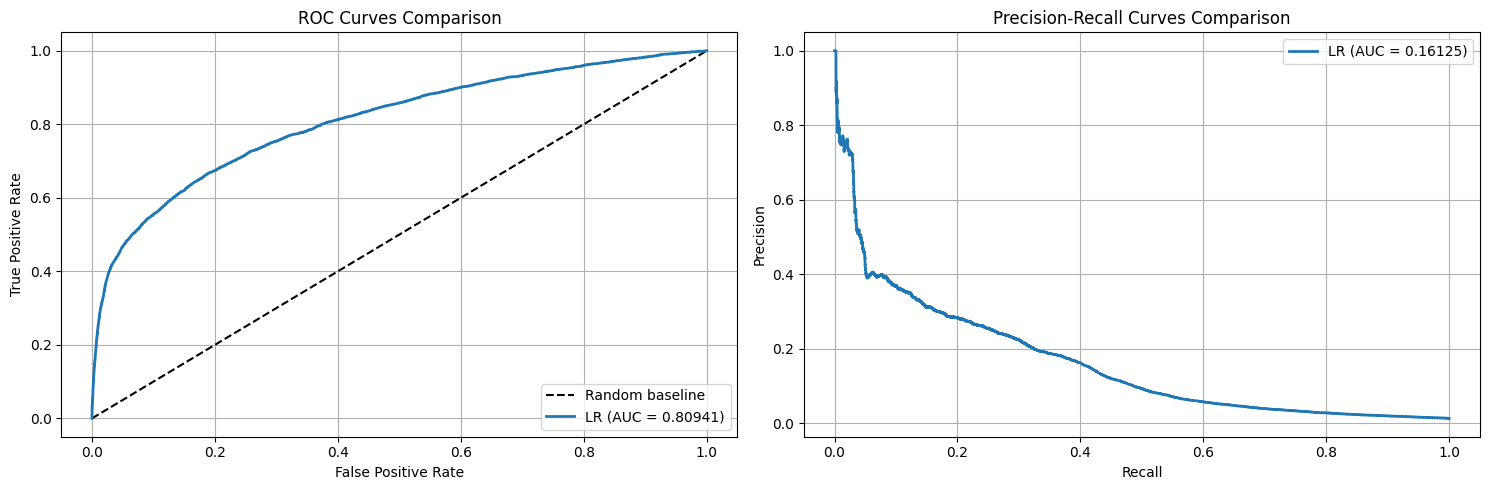

In [16]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1',C=1,random_state=42, solver='liblinear')
)
to_be_tested = {'LR':pipeline}
paint_graphics(to_be_tested, numeric_cols, 'train + test')

# Model Training and Evaluation

From now on, different non-linear models will be trained and evaluated.

## Decission Tree

Two decission trees are trained, one with numeric columns and other with numeric and categorical columns. The results from both models will be compared.

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/lucas/zrive-ds/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Top validation ROC_AUC: 0.8168865018403612


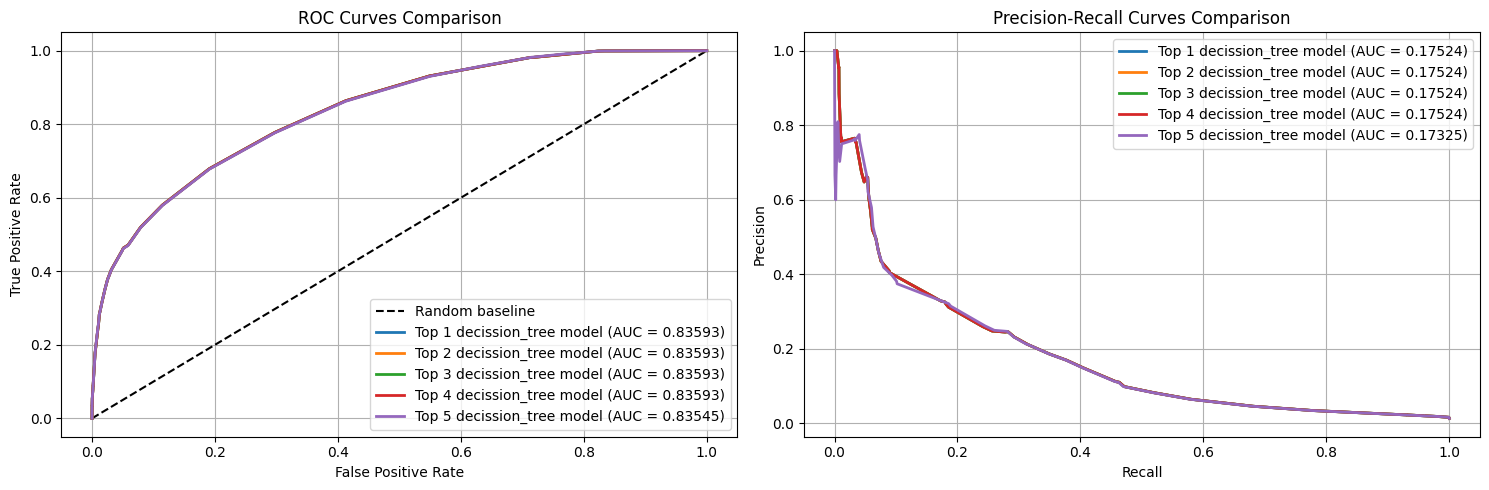

In [17]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [40, 60, 80],
    'criterion': ['log_loss', 'entropy']
}

tscv = TimeSeriesSplit(n_splits=3)

dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='roc_auc',
    cv = tscv,
    n_jobs=-1,            
    verbose=1
)

best_decision_tree_num = paint_graphics(dt_grid, numeric_cols, 'decission_tree')

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/lucas/zrive-ds/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Top validation ROC_AUC: 0.8195636650232299


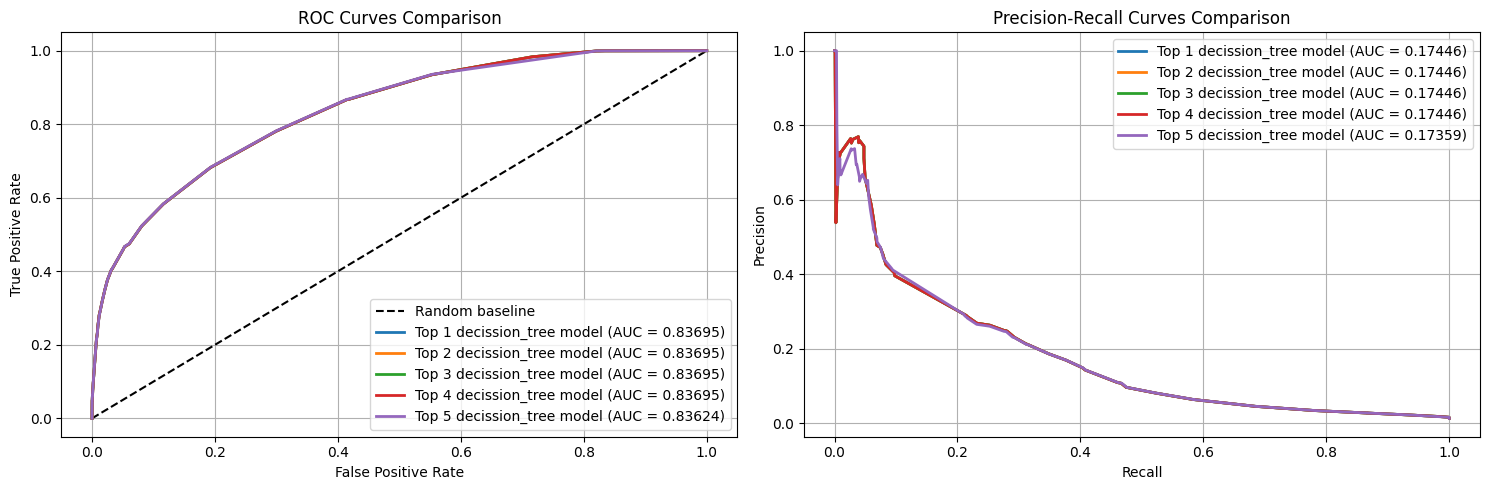

In [18]:
best_decision_tree_numcat = paint_graphics(dt_grid, numeric_cols+categorical_cols,'decission_tree')

DecisionTreeClassifier(criterion='log_loss', max_depth=7, min_samples_leaf=40,
                       random_state=42)


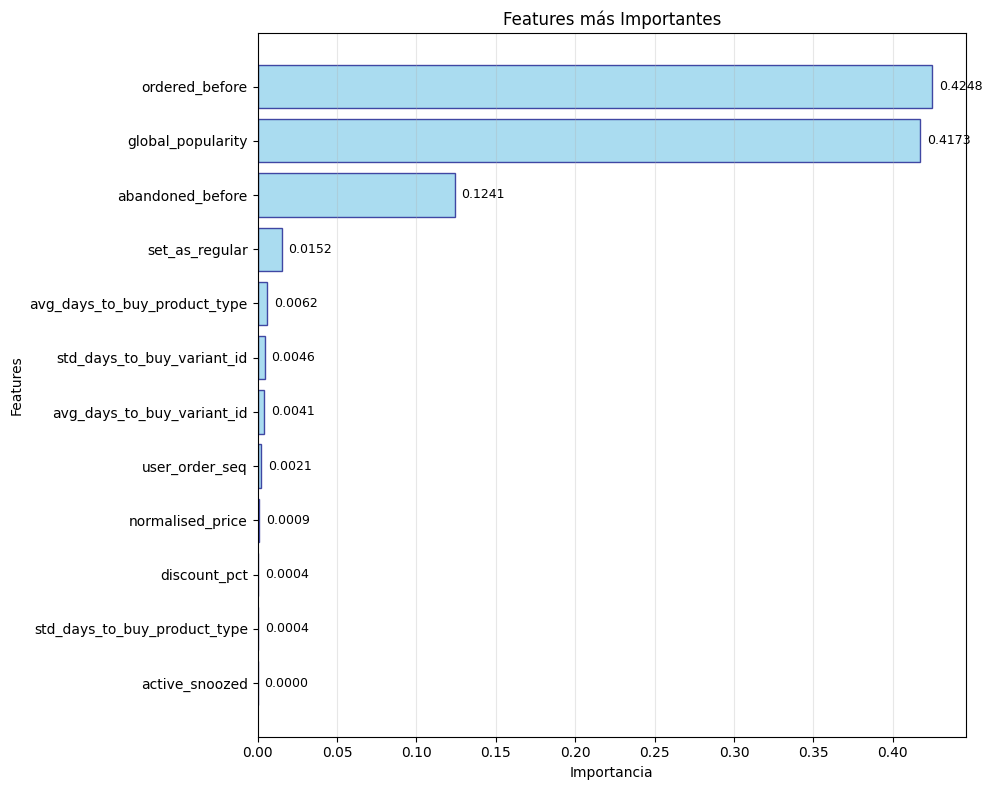

,feature,importance
1,ordered_before,0.424756
7,global_popularity,0.417252
2,abandoned_before,0.124106
4,set_as_regular,0.015212
10,avg_days_to_buy_product_type,0.006157
9,std_days_to_buy_variant_id,0.004597
8,avg_days_to_buy_variant_id,0.004055
0,user_order_seq,0.002144
5,normalised_price,0.000919
6,discount_pct,0.000434


In [19]:
print(best_decision_tree_num)
plot_feature_importance(best_decision_tree_num,numeric_cols)

DecisionTreeClassifier(criterion='log_loss', max_depth=7, min_samples_leaf=60,
                       random_state=42)


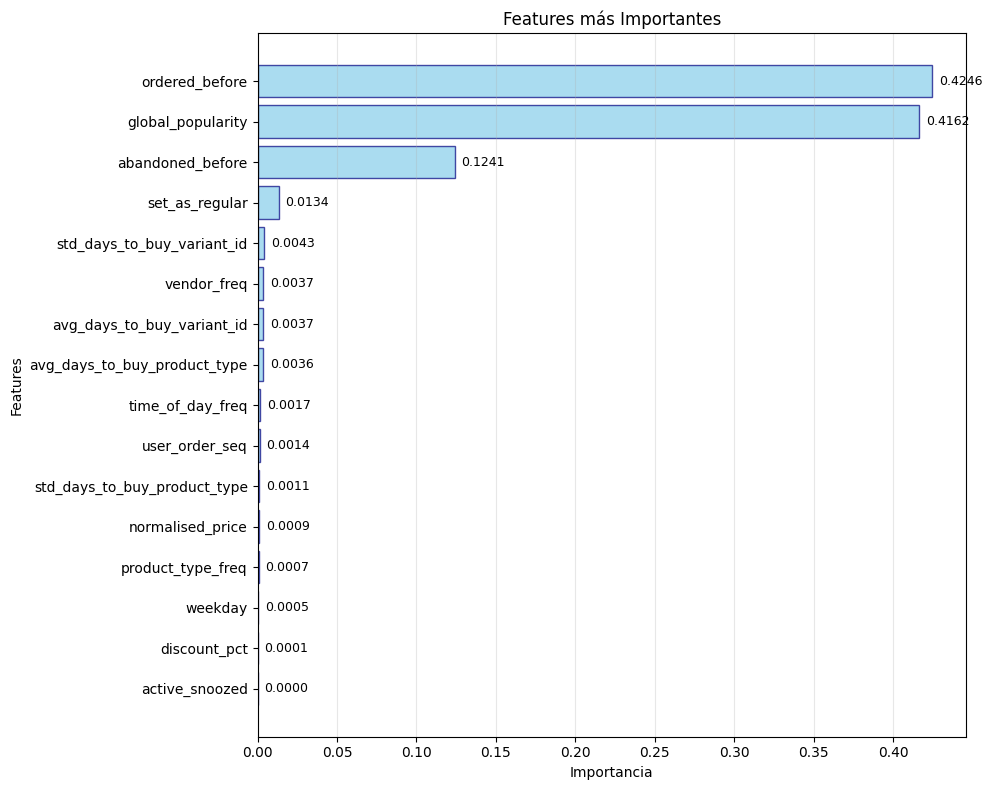

,feature,importance
1,ordered_before,0.424637
7,global_popularity,0.416226
2,abandoned_before,0.124071
4,set_as_regular,0.013351
9,std_days_to_buy_variant_id,0.004274
15,vendor_freq,0.003716
8,avg_days_to_buy_variant_id,0.003715
10,avg_days_to_buy_product_type,0.003575
14,time_of_day_freq,0.001729
0,user_order_seq,0.001388


In [20]:
print(best_decision_tree_numcat)
plot_feature_importance(best_decision_tree_numcat,numeric_cols+categorical_cols)

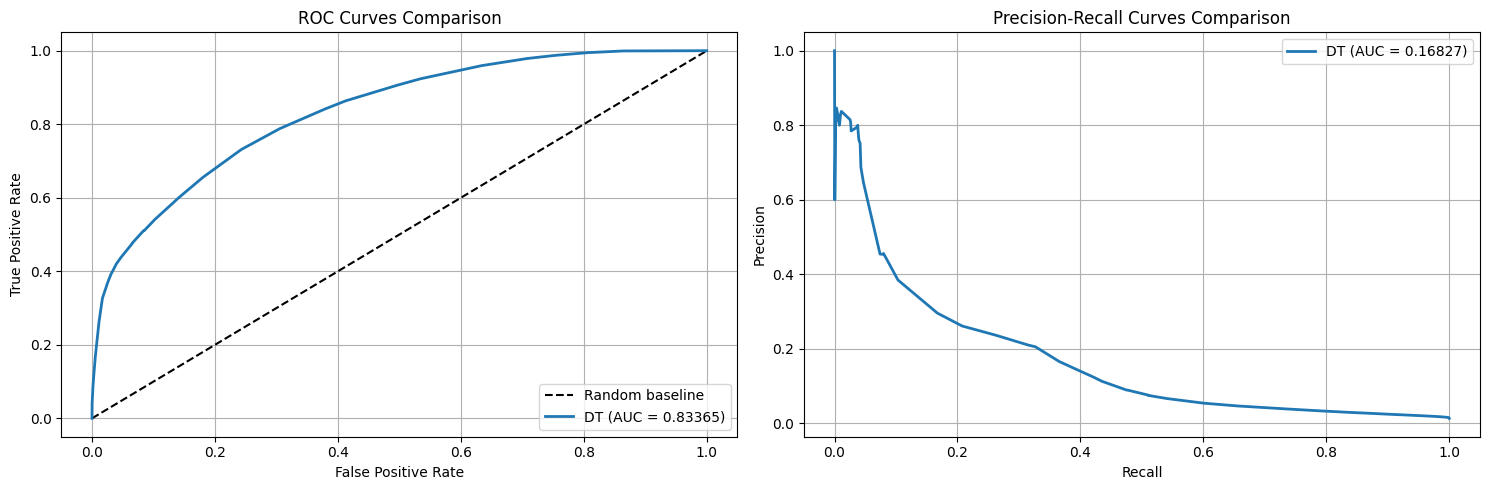

In [21]:
model = {'DT':DecisionTreeClassifier(criterion='log_loss', max_depth=7, min_samples_leaf=60,random_state=42)}
selected_cols = ['ordered_before','global_popularity','abandoned_before']
paint_graphics(model,selected_cols,'train + test')

Results from both models are not different and the importance of features does not change remarkably. The training with the three most important features seemed to show similar results. The model trained with numerical variables will be compared with other algorithms.

In [22]:
best_decision_tree = best_decision_tree_num

## Gradient Boosting

Top validation ROC_AUC: 0.8300506948176215


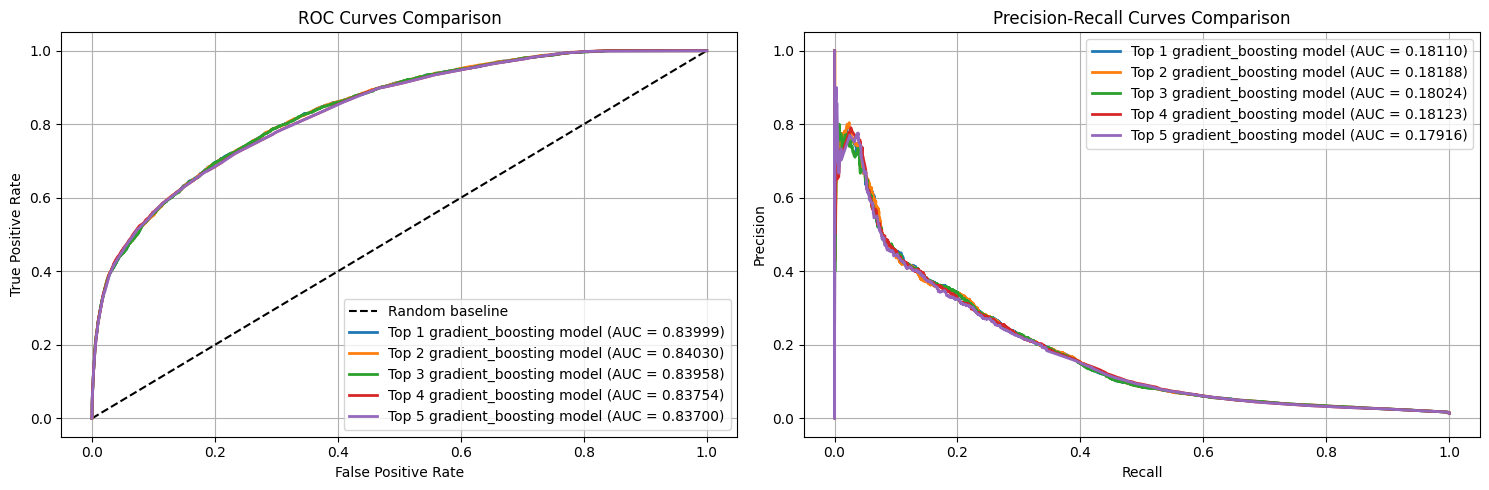

In [23]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1],        
    'n_estimators': [100, 200, 300] 
}

tscv = TimeSeriesSplit(n_splits=3)

gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1
)

best_gradient_boost = paint_graphics(gb_grid, numeric_cols, 'gradient_boosting')

GradientBoostingClassifier(n_estimators=200, random_state=42)


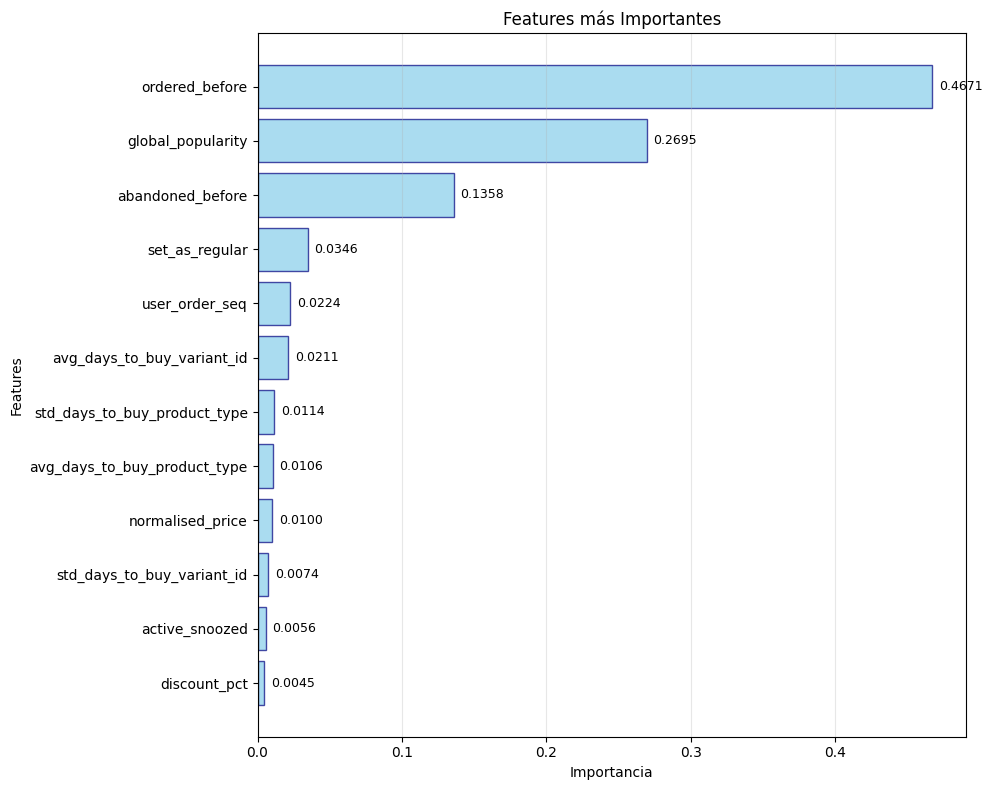

,feature,importance
1,ordered_before,0.467095
7,global_popularity,0.269524
2,abandoned_before,0.135815
4,set_as_regular,0.034646
0,user_order_seq,0.022403
8,avg_days_to_buy_variant_id,0.021063
11,std_days_to_buy_product_type,0.011388
10,avg_days_to_buy_product_type,0.010552
5,normalised_price,0.010017
9,std_days_to_buy_variant_id,0.007416


In [24]:
print(best_gradient_boost)
plot_feature_importance(best_gradient_boost,numeric_cols)

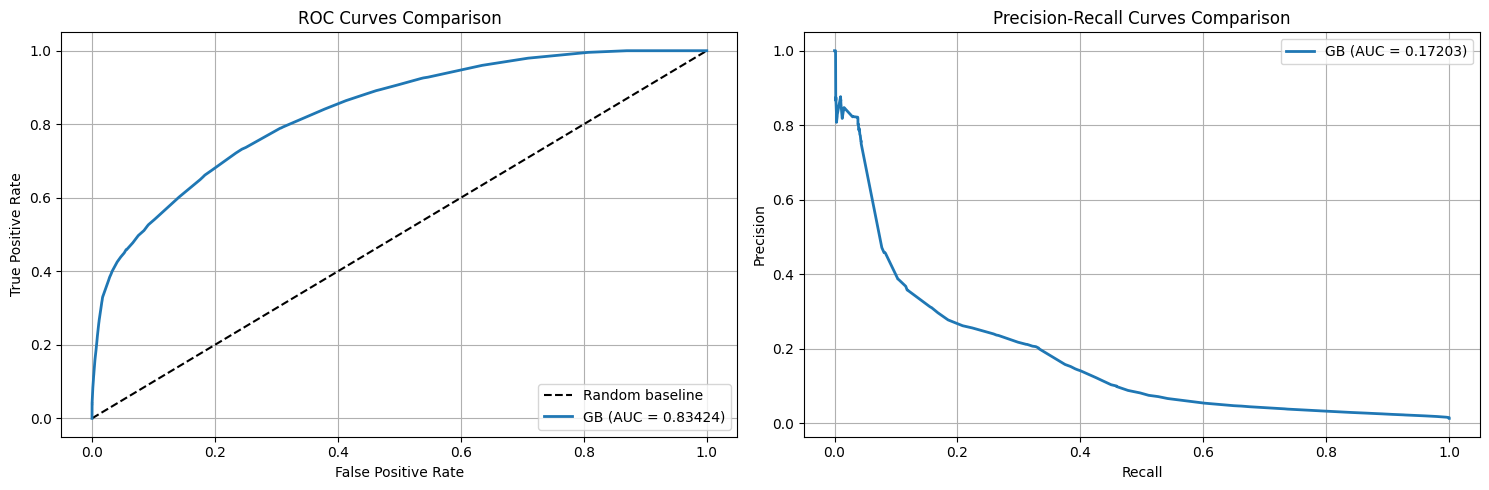

In [25]:
model = {'GB':GradientBoostingClassifier(n_estimators=200,learning_rate=0.01)}
selected_cols = ['ordered_before','global_popularity','abandoned_before']
paint_graphics(model,selected_cols,'train + test')

Gradient Boosting shows a similar behaviour to decission tree and the importance of features is practically the same.

## Random Forest

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=  28.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=  42.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=  52.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=  54.8s
[CV] END .....................max_depth=10, n_estimators=300; total time= 1.3min
[CV] END .....................max_depth=20, n_estimators=100; total time= 1.4min
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.6min
[CV] END .....................max_depth=20, n_estimators=200; total time= 1.4min
[CV] END .....................max_depth=10, n_estimators=200; total time= 1.9min
[CV] END .....................max_depth=20, n_estimators=100; total time= 2.2min
[CV] END .....................max_depth=10, n_estimators=300; total time= 2.6min
[CV] END .....................max_depth=20, n_est

/home/lucas/zrive-ds/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Top validation ROC_AUC: 0.8102381333348155


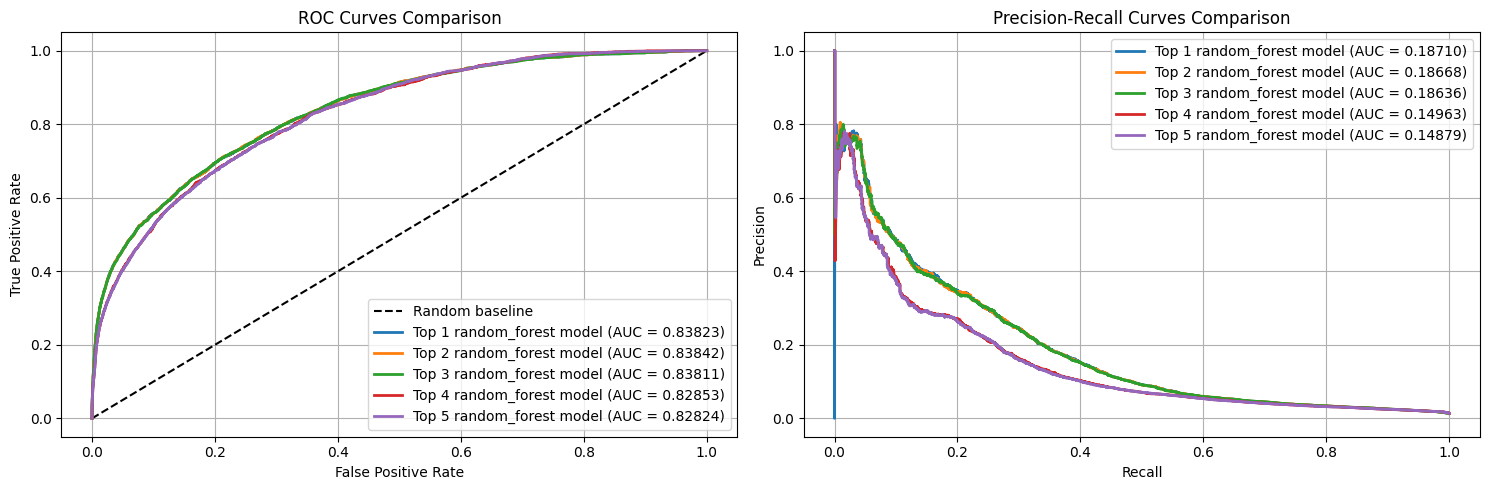

In [26]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20]
}

tscv = TimeSeriesSplit(n_splits=3)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,               
    scoring='roc_auc',  
    n_jobs=-1,           
    verbose=2
)

best_random_forest = paint_graphics(rf_grid, numeric_cols,'random_forest')

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)


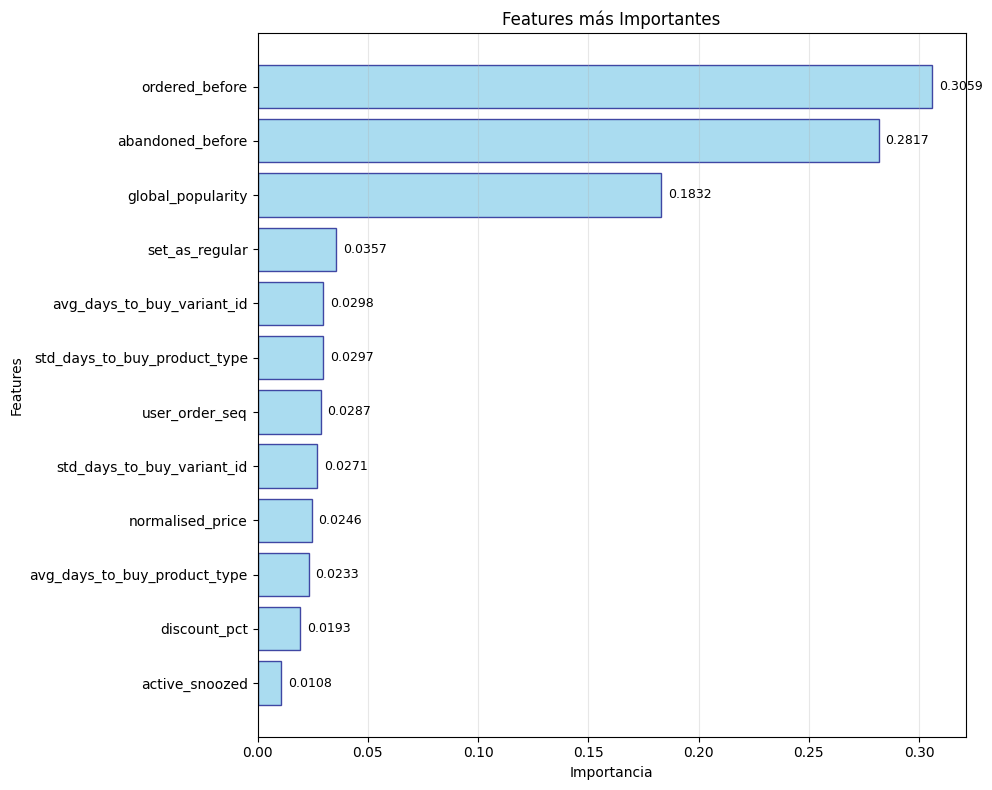

,feature,importance
1,ordered_before,0.305918
2,abandoned_before,0.281738
7,global_popularity,0.183171
4,set_as_regular,0.035733
8,avg_days_to_buy_variant_id,0.029839
11,std_days_to_buy_product_type,0.029731
0,user_order_seq,0.028715
9,std_days_to_buy_variant_id,0.027126
5,normalised_price,0.024647
10,avg_days_to_buy_product_type,0.023265


In [27]:
print(best_random_forest)
plot_feature_importance(best_random_forest,numeric_cols)

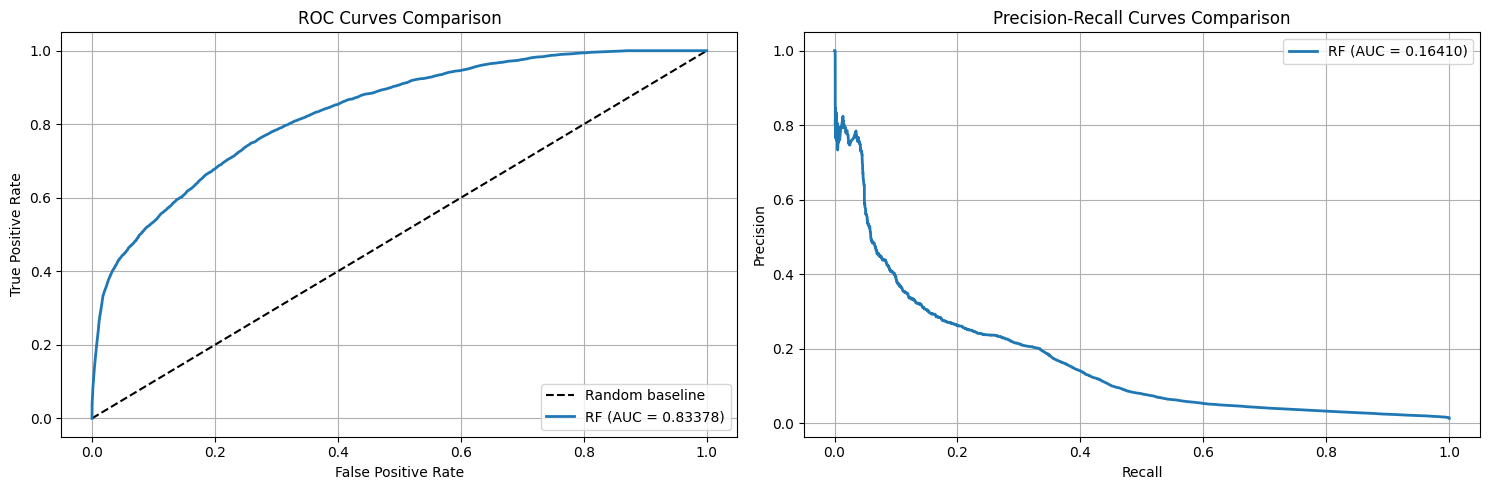

In [28]:
model = {'RF': RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)}
selected_cols = ['ordered_before','global_popularity','abandoned_before']
paint_graphics(model, selected_cols, 'train + test')

## XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Top validation ROC_AUC: 0.8291931221559651


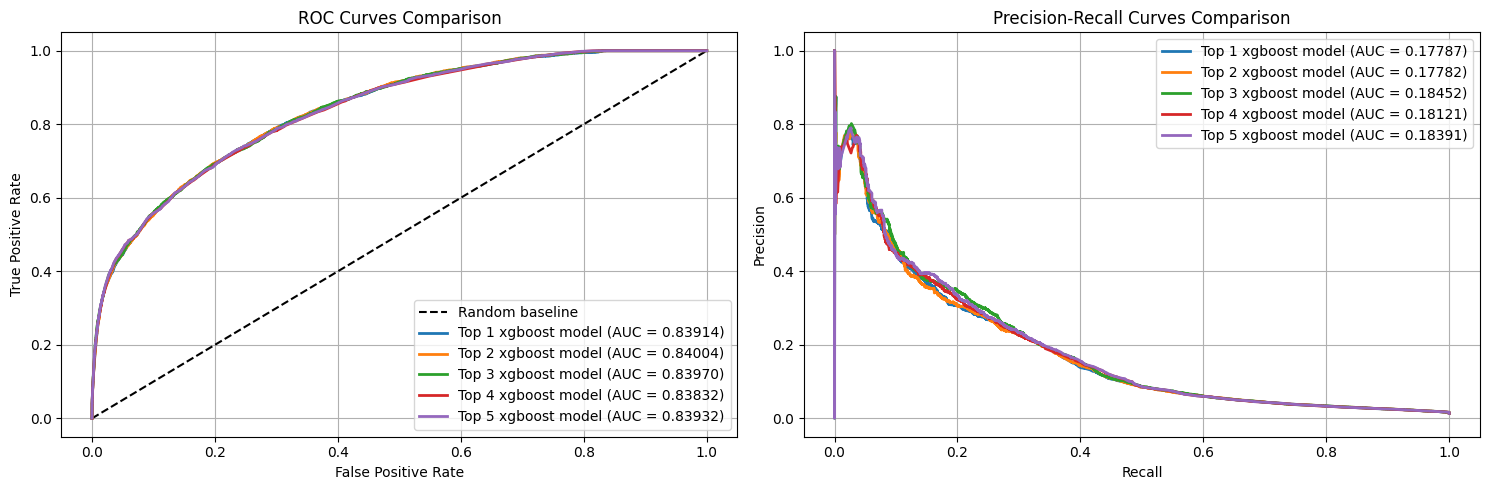

In [29]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='auc'
)

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1
)

best_xgboost = paint_graphics(xgb_grid, numeric_cols, 'xgboost')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


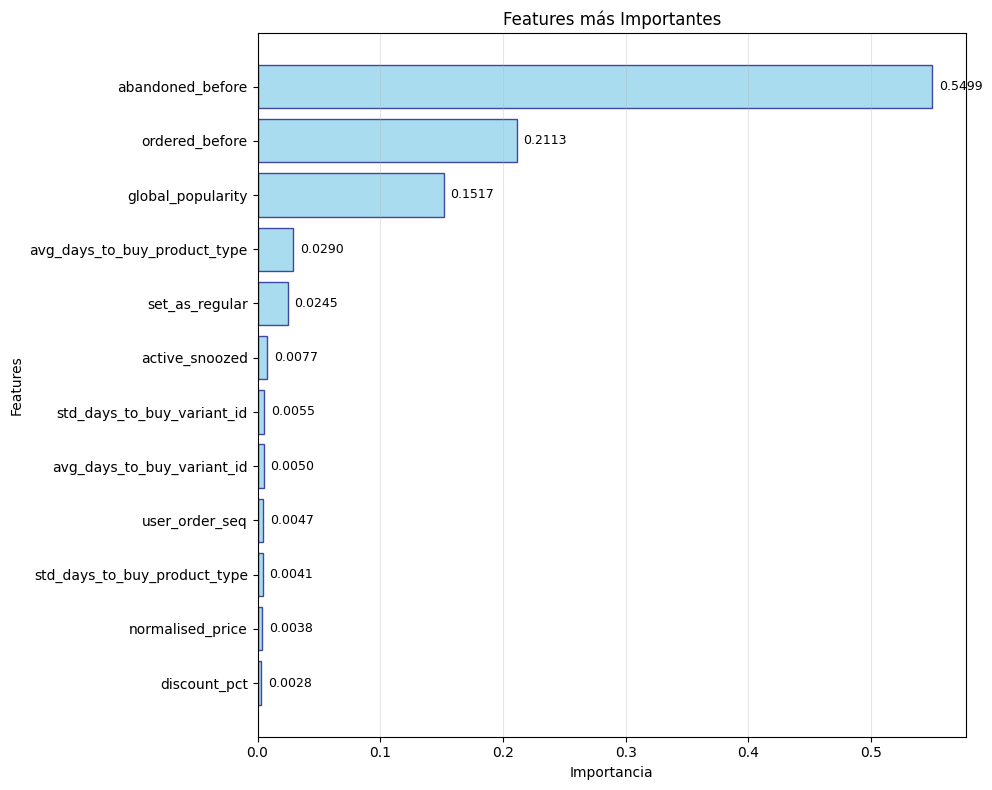

,feature,importance
2,abandoned_before,0.549859
1,ordered_before,0.211341
7,global_popularity,0.151746
10,avg_days_to_buy_product_type,0.028967
4,set_as_regular,0.024461
3,active_snoozed,0.007740
9,std_days_to_buy_variant_id,0.005452
8,avg_days_to_buy_variant_id,0.004991
0,user_order_seq,0.004686
11,std_days_to_buy_product_type,0.004098


In [30]:
print(best_xgboost)
plot_feature_importance(best_xgboost, numeric_cols)

## Model Comparison

The best models for each algorithm are tested with test set and compared with each other and with the baseline to decide which of them will be used in production.

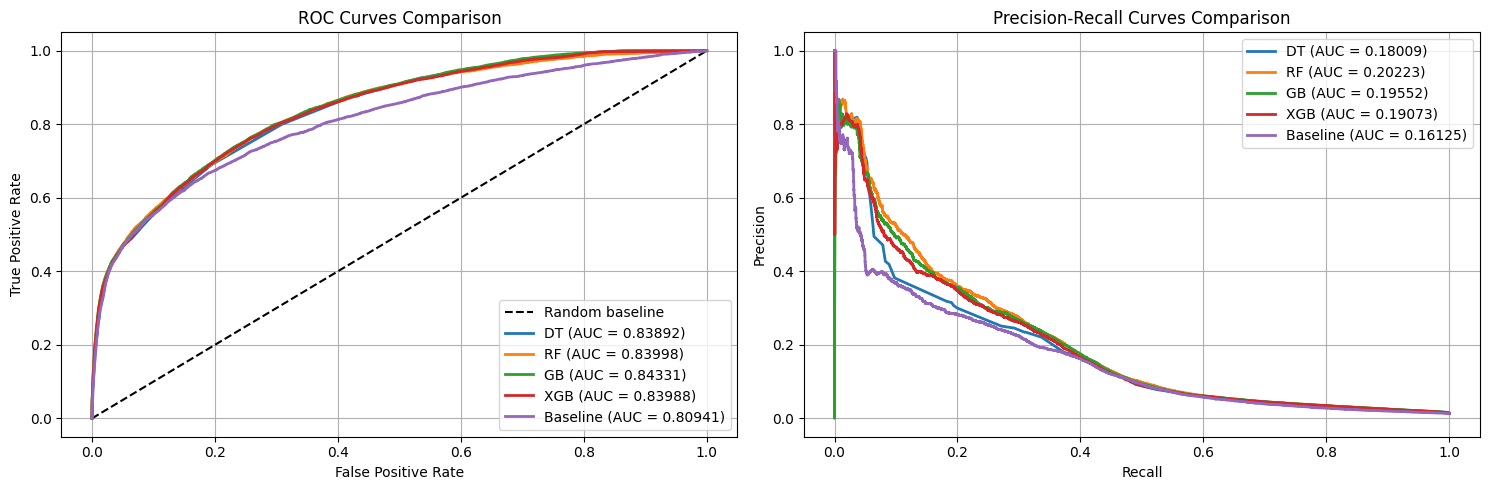

In [31]:
baseline = pipeline.fit(X_train[numeric_cols], y_train)
trained_models = {
    'DT':best_decision_tree,
    'RF':best_random_forest,
    'GB':best_gradient_boost,
    'XGB':best_xgboost,
    'Baseline': baseline
}

paint_graphics(trained_models,numeric_cols,'test')

Threshold will be determined using the associated recall.

In [41]:
probs = best_gradient_boost.predict_proba(X_test[numeric_cols])[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
    
    # Encontrar el índice del recall más cercano al deseado
idx = np.argmin(np.abs(recalls - 0.6))

# Si el índice es el último, usar el penúltimo threshold
if idx == len(thresholds):
    idx = len(thresholds) - 1

threshold = thresholds[idx]
actual_recall = recalls[idx]
precision = precisions[idx]

print(f'Threshold: {threshold}')
print(f'Recall: {actual_recall}')

Threshold: 0.021798193308869247
Recall: 0.600030969340353


#### Conclusions

- Given the results with test set, seems correct to select Gradient Boosting as the model used in production. However, any of the non linear models significantly improve the baseline.

- The optimum hyperparameters for gradient boosting are 200 estimators and learning rate = 0.01.

- The threshold used is determined taking in account what we think is an acceptable recall (around 0.6). This value results to be around 0.217

- For the selected threshold even the baseline model seems to behave similar to other models.